# Proyecto

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesor: Pablo Badilla
- Auxiliar: Ignacio Meza D.
- Ayudante: Patricio Ortiz

*Por favor, lean detalladamente las instrucciones de la tarea antes de empezar a escribir.*




# Proyecto

### Equipo:

- \<Primer integrante: Nicolás Gatica\>
- \<Segundo integrante: Cristóbal Igor\>

- \<Nombre de usuarios en Codalab: cigor\>

- \<Nombre del Equipo en Codalab\>

### Link de repositorio de GitHub: `\<https://github.com/ngatica/LaboratoriosMDS\>`




## 1. Introducción

El objetivo de este proyecto consiste en medir el éxito que tendrá una película. Esto se ve reflejado en dos métricas; los votos promedios, que seran categorizados en 'Negative', 'Mixed', 'Mostly Positive', 'Positive', 'Very Positive'; y la cantidad de dinero recaudado luego de ser estrenadas.

Los datos que se proveen es un dataset con 6451 ejemplos que describen una observación de películas y series ya estrenadas. Esto a través de su título, presupuesto, duración, lema, creditos, generos, lenguaje, resumen, productoras, fecha de lanzamiento y palabras claves.

En total son 13 atributos, 11 correspondientes a las variables mencionadas y 2 correspondientes a la variables objetivos. Esta últimas son de tipo; categórico, asociado a la características de los votos de de las películas (negativos, mixto, mayormente positivo, positivo, y muy positivos); y númerico asociado a las recaudaciones logradas por la película.

La primera tarea, correspondiente a la clasificación de los votos promedios, se evalua en base a la métrica F1-macro ya que esta combina la precisión y la sensibilidad que tiene un test, calculando la media armónica entre ambas. Al tener un problema multiclase, la extensión macro obtiene el promedio de los F1 resultantes para cada una de las etiquetas.

La segunda tarea, correspondiente a la predicción de la recaudación, se evalua en base a la métrica R2 ya que esta es una medida estadística que muestra qué tan cerca se encuentran los puntos de datos sobre la linea de regresión.

Nuestra propuesta para resolver ambos problemas consistió, de forma resumida, en primero crear caracteristicas a partir de las ya existentes, y también vectorizar las variables en formato de texto.
Luego, para clasificar y predecir se utilizaron principalmente modelos ensamblados, esto dado que demostraron tener un mejor desempeño que los modelos más básicos.
Por último, partir de estos modelos se procedió a mejorar los parámetros asociados tanto a los modelos, como a los métodos de vectorización de los atributos de texto.

En base a este procedimiento nuestros modelos cumplieron con las expectativas, lograron tener una buena capacidad de generalización y robustez, superando en ambos casos al baseline propuesto en la competencia, y destacando en la predicción de la recaudación de las películas.

---
## 2. Prepración y Análisis Exploratorio de Datos

---
### 2.1 Carga y Preparación de los datos

In [2]:
## Librerias
#!pip install -q pyarrow
#!pip install -q pandas
#!pip install -q sklearn
#!pip install -q xgboost
#!pip install -q lightgbm
#!pip install -q nltk
#!pip install -q seaborn

import pandas as pd
import numpy as np

# Pre-procesamiento
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn import linear_model
from sklearn.linear_model import HuberRegressor


import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
import plotly.express as px

# Texto

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize  
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.utils import class_weight

from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

import os
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
##  Código Preparación de Datos.

## Leyendo parquets
data_numerica=pd.read_parquet('train_numerical_features.parquet')
data_text=pd.read_parquet('train_text_features.parquet')

## Merge data
data=data_numerica.merge(data_text, how='inner', on=['id', 'title', 'credits', 'tagline'])

## Eliminando columnas
data.drop(columns=['poster_path', 'backdrop_path', 'recommendations'], inplace=True)

## Filtrado revenue
data=data[~(data.revenue==0)]

## Filtrado release_date o runtime nulos
data=data[(~(data.release_date.isna()) | (data.runtime.isna()))]

## Fechas a datetime
data['release_date']=pd.to_datetime(data.release_date)

## Filtro status
data=data[data.status=='Released']

## Valores nulos de categóricas a string vacio
data[data.select_dtypes(include='object').columns]=data[data.select_dtypes(include='object').columns].fillna('')

## Discretizando los votos
labels=['Negative', 'Mixed', 'Mostly Positive', 'Positive', 'Very Positive']
data['label']=pd.cut(data.vote_average, bins=[0, 5, 6, 7, 8, 10], labels=labels)

## Eliminando columnas vote average e id
data.drop(columns=['vote_average', 'id'], inplace=True)

## Renonmbrado columnas:
data.rename(columns={'revenue': 'target'}, inplace=True)

## Reseteando index
data.reset_index(inplace=True, drop=True)

---
### 2.2 EDA

#### Análisis de tipos de datos y distribuciones de las variables

In [4]:
# primera visualización del dataset
data.head(3)

title       budget       target  \
0  Fantastic Beasts: The Secrets of Dumbledore  200000000.0  400000000.0   
1                         Sonic the Hedgehog 2  110000000.0  393000000.0   
2                                The Lost City   74000000.0  164289828.0   

   runtime    status                                     tagline  \
0    142.0  Released                        Return to the magic.   
1    122.0  Released                  Welcome to the next level.   
2    112.0  Released  The adventure is real. The heroes are not.   

                                             credits  \
0  Jude Law-Eddie Redmayne-Mads Mikkelsen-Ezra Mi...   
1  James Marsden-Ben Schwartz-Tika Sumpter-Natash...   
2  Sandra Bullock-Channing Tatum-Daniel Radcliffe...   

                           genres original_language  \
0        Fantasy-Adventure-Action                en   
1  Action-Adventure-Family-Comedy                en   
2         Action-Adventure-Comedy                en   

                                            overview  \
0  Professor Albus Dumbledore knows the powerful ...   
1  After settling in Green Hills Sonic is eager t...   
2  A reclusive romance novelist was sure nothing ...   

                                production_companies release_date  \
0                 Warner Bros. Pictures-Heyday Films   2022-04-06   
1  Original Film-Blur Studio-Marza Animation Plan...   2022-03-30   
2  Paramount-Fortis Films-3dot Productions-Exhibi...   2022-03-24   

                                            keywords            label  
0  magic-curse-fantasy world-wizard-magical creat...  Mostly Positive  
1  sequel-based on video game-hedgehog-live actio...         Positive  
2                               duringcreditsstinger  Mostly Positive

In [5]:
# información básica del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6451 entries, 0 to 6450
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 6451 non-null   object        
 1   budget                6451 non-null   float64       
 2   target                6451 non-null   float64       
 3   runtime               6451 non-null   float64       
 4   status                6451 non-null   object        
 5   tagline               6451 non-null   object        
 6   credits               6451 non-null   object        
 7   genres                6451 non-null   object        
 8   original_language     6451 non-null   object        
 9   overview              6451 non-null   object        
 10  production_companies  6451 non-null   object        
 11  release_date          6451 non-null   datetime64[ns]
 12  keywords              6451 non-null   object        
 13  label             

In [6]:
# Conteo de los tipos de variables
data.dtypes.value_counts().plot(kind="barh", figsize=(20,8))
for i, v in enumerate(data.dtypes.value_counts()):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 20)
plt.xlabel("Value Count")
plt.ylabel("Data Types")
plt.title("Count Columns By Datatypes")

Text(0.5, 1.0, 'Count Columns By Datatypes')

Se debe tener ojo con el tratamiento de los datos para algunas columnas como credits, genres o production_companies dado que estas cuentan con una lista de valores diferentes dentro de la celda y funciones como el conteo de variables categóricas o la extracción de datos estadísticos de estas celdas pueden resultar no triviales.

In [7]:
data.describe()

budget        target      runtime
count  6.451000e+03  6.451000e+03  6451.000000
mean   2.986470e+07  9.258012e+07   108.843590
std    4.180378e+07  1.756207e+08    20.173254
min    0.000000e+00  1.000000e+00     4.000000
25%    2.600000e+06  7.937442e+06    95.000000
50%    1.500000e+07  3.142933e+07   105.000000
75%    3.900000e+07  9.822657e+07   119.000000
max    3.800000e+08  2.847246e+09   366.000000

Esta descripción nos dice que debemos tener ojo con las variables 'budget' y 'runtime' dado que sus valores mínimos (y máximos también en el caso de runtime) se encuentran fuera de lo normal y esto podría perjudicar al aprendizaje del modelo a implementar.

In [8]:
# Descripción de todas las columnas del dataset
data.describe(include='all')

C:\Users\ngati\AppData\Local\Temp\ipykernel_8700\159782272.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include='all')


title        budget  \
count                                          6451  6.451000e+03   
unique                                         6451           NaN   
top     Fantastic Beasts: The Secrets of Dumbledore           NaN   
freq                                              1           NaN   
first                                           NaN           NaN   
last                                            NaN           NaN   
mean                                            NaN  2.986470e+07   
std                                             NaN  4.180378e+07   
min                                             NaN  0.000000e+00   
25%                                             NaN  2.600000e+06   
50%                                             NaN  1.500000e+07   
75%                                             NaN  3.900000e+07   
max                                             NaN  3.800000e+08   

              target      runtime    status tagline credits genres  \
count   6.451000e+03  6451.000000      6451    6451    6451   6451   
unique           NaN          NaN         1    5685    6450   1574   
top              NaN          NaN  Released                  Drama   
freq             NaN          NaN      6451     746       2    403   
first            NaN          NaN       NaN     NaN     NaN    NaN   
last             NaN          NaN       NaN     NaN     NaN    NaN   
mean    9.258012e+07   108.843590       NaN     NaN     NaN    NaN   
std     1.756207e+08    20.173254       NaN     NaN     NaN    NaN   
min     1.000000e+00     4.000000       NaN     NaN     NaN    NaN   
25%     7.937442e+06    95.000000       NaN     NaN     NaN    NaN   
50%     3.142933e+07   105.000000       NaN     NaN     NaN    NaN   
75%     9.822657e+07   119.000000       NaN     NaN     NaN    NaN   
max     2.847246e+09   366.000000       NaN     NaN     NaN    NaN   

       original_language overview production_companies         release_date  \
count               6451     6451                 6451                 6451   
unique                34     6449                 5621                 4423   
top                   en                     Paramount  2005-09-16 00:00:00   
freq                5587        3                   75                    7   
first                NaN      NaN                  NaN  1916-09-04 00:00:00   
last                 NaN      NaN                  NaN  2022-06-01 00:00:00   
mean                 NaN      NaN                  NaN                  NaN   
std                  NaN      NaN                  NaN                  NaN   
min                  NaN      NaN                  NaN                  NaN   
25%                  NaN      NaN                  NaN                  NaN   
50%                  NaN      NaN                  NaN                  NaN   
75%                  NaN      NaN                  NaN                  NaN   
max                  NaN      NaN                  NaN                  NaN   

       keywords            label  
count      6451             6451  
unique     6243                5  
top              Mostly Positive  
freq        152             2983  
first       NaN              NaN  
last        NaN              NaN  
mean        NaN              NaN  
std         NaN              NaN  
min         NaN              NaN  
25%         NaN              NaN  
50%         NaN              NaN  
75%         NaN              NaN  
max         NaN              NaN

-En la columna 'overview' hay dos datos repetidos y en la columna 'credits' también por lo que podría ser útil revisar qué pasa ahí. 

-El 87% de las películas están en inglés (en).

-Las fechas de las películas van desde 1916-09-04 hasta el 2022-06-01.

C:\Users\ngati\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6451


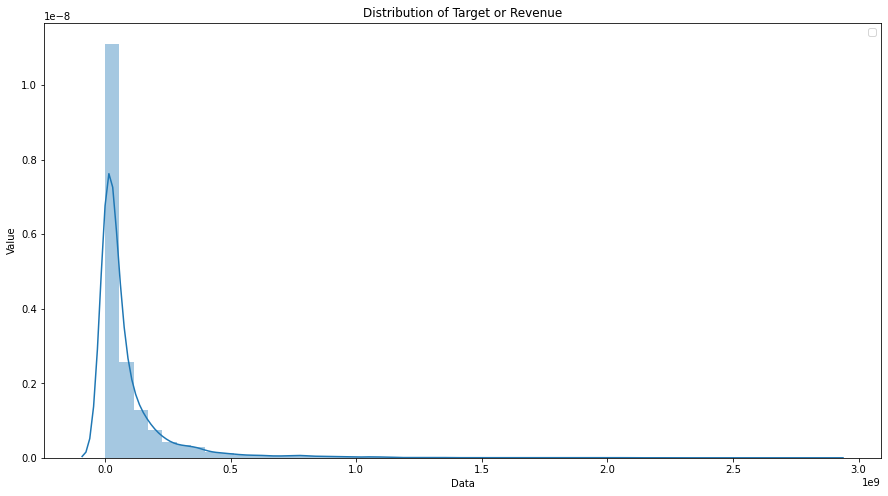

In [11]:
target_df = data[['title', 'target']].sort_values('target')
print(len(target_df))
target_boxplot = target_df[['target']]
plt.figure(figsize=(15,8))
sns.distplot(target_boxplot)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Distribution of Target or Revenue')
plt.legend()
plt.show()

C:\Users\ngati\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6451


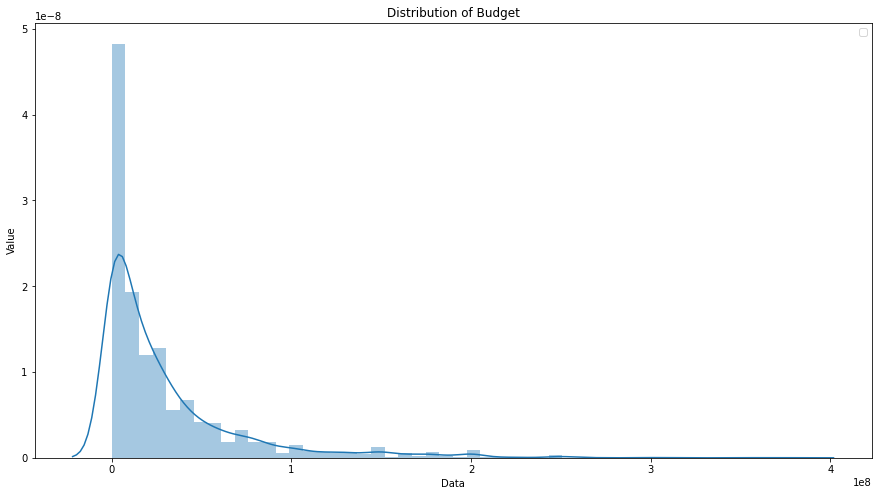

In [12]:
budget_df = data[['title', 'budget']].sort_values('budget')
print(len(budget_df))
budget_boxplot = budget_df[['budget']]
plt.figure(figsize=(15,8))
sns.distplot(budget_boxplot)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Distribution of Budget')
plt.legend()
plt.show()

C:\Users\ngati\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6451


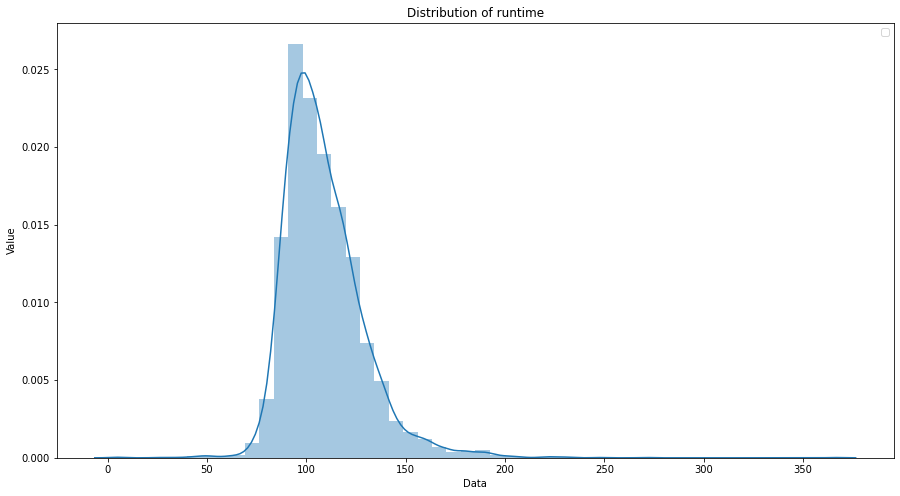

In [13]:
runtime_df = data[['title', 'runtime']].sort_values('runtime')
print(len(runtime_df))
runtime_boxplot = runtime_df[['runtime']]
plt.figure(figsize=(15,8))
sns.distplot(runtime_boxplot)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Distribution of runtime')
plt.legend()
plt.show()

En general las 3 variables mantienen una distribución uniforme y con una leve inclinación hacia el eje 0.

#### Generación de visualizaciones de algunas interacciones de variables

In [14]:
# Scatter Matrix con las variables numéricas
variables_interes = [
    "budget",
    "runtime"
]

fig = px.scatter_matrix(
    data.sort_values(by="target", ascending=True),
    dimensions=variables_interes,
    height=1000,
    title="Análisis Bivariado",
    color='target'
)
fig.update_traces(diagonal_visible=False)
fig.show()

Resulta interesante la agrupación de los puntos sobre los target de bajos valores, mientras que los target que se encuentran con valores más alto mantienen una característica más propia o particular con respecto a las variables de runtime y budget.

Text(0.5, 1.0, 'Missing Value count By Features')

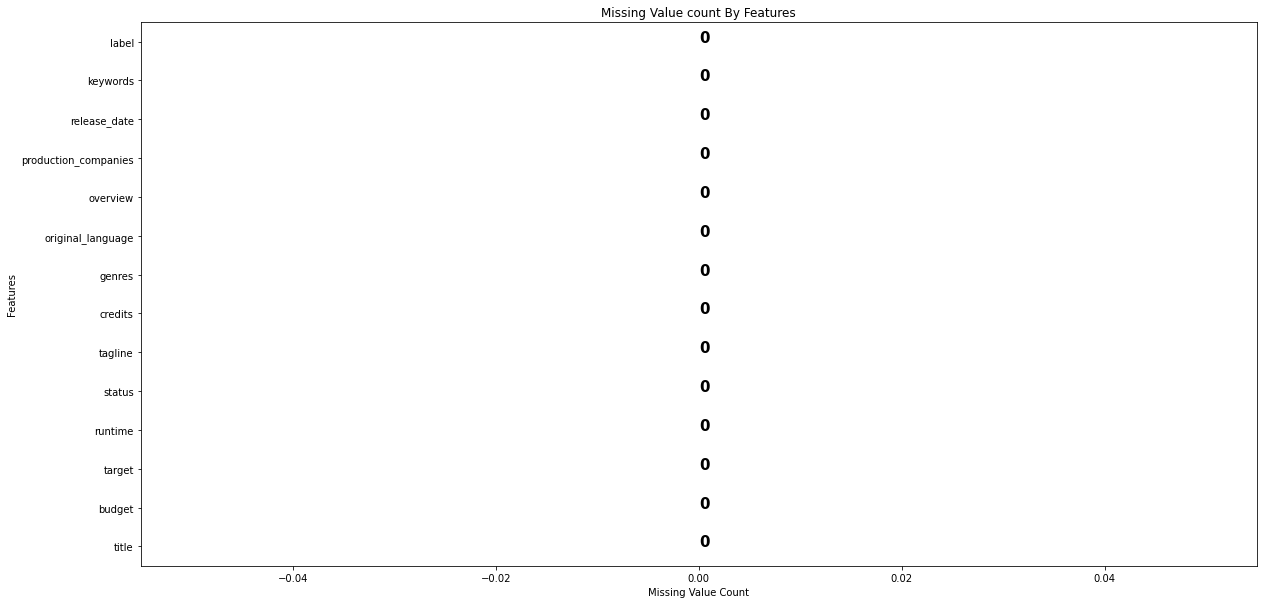

In [15]:
# Conteo de los valores faltantes
data.isna().sum().plot(kind="barh", figsize=(20,10))
for i, v in enumerate(data.isna().sum()):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 15)
plt.xlabel("Missing Value Count")
plt.ylabel("Features")
plt.title("Missing Value count By Features")

No hay valores faltantes para ninguna columna del dataset, por lo que la preparación sobre los valores nan de los datos resultó bien

#### Proyección de los datos con UMAP

In [ ]:
#pip install umap-learn

In [443]:
import umap.umap_ as umap

from sklearn.preprocessing import StandardScaler

# Proyección en 2D
reducer = umap.UMAP()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_columns = list(data.drop(columns=['target', 'label']).select_dtypes(include=numerics).columns)
umap_data = data[num_columns].values

scaled_data = StandardScaler().fit_transform(umap_data)

embedding = reducer.fit_transform(scaled_data)
embedding.shape

(6451, 3)

In [442]:
df_umap = pd.DataFrame(embedding, columns = ['PC1','PC2'])
px.scatter(df_umap, x='PC1', y='PC2', color=data['label'])

In [445]:
# Proyección en 3D
reducer = umap.UMAP(n_components=3)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_columns = list(data.drop(columns=['target', 'label']).select_dtypes(include=numerics).columns)
umap_data = data[num_columns].values

scaled_data = StandardScaler().fit_transform(umap_data)

embedding = reducer.fit_transform(scaled_data)
embedding.shape
                             
df_umap = pd.DataFrame(embedding, columns = ['PC1','PC2','PC3'])
px.scatter_3d(df_umap, x='PC1', y='PC2', z='PC3', color=data['label'])

Con el dataset sin un mayor tratamiento de los datos resulta dificil de diferenciar en cuanto a los labels con la reducción de dimensionalidad de 3 componentes, esto puede apuntar a que la clasificación requiera de un buen preprocesamiento, o de lo contrario no será fácil diferenciar las 5 clases diferentes.

#### Histogramas de frecuencia sobre las variables de lenguaje y label

In [174]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots
#categorical = data.select_dtypes(["category"]).columns
categorical = ['original_language']
n_cols = 1
fig = make_subplots(
    rows=len(categorical) // n_cols + 1, cols=n_cols, subplot_titles=categorical
)
dataset = data.copy()
for idx, col in enumerate(categorical):
    row_idx = idx // n_cols + 1
    col_idx = idx % n_cols + 1

    dataset = dataset.loc[:, col]
    hist = go.Histogram(x=dataset, name=col)
    fig.add_trace(hist, row=row_idx, col=col_idx)


fig.show()

In [175]:
#Esto muta el dataset

import plotly.graph_objects as go
from plotly.subplots import make_subplots
#categorical = data.select_dtypes(["category"]).columns
categorical = ['label']
n_cols = 1
fig = make_subplots(
    rows=len(categorical) // n_cols + 1, cols=n_cols, subplot_titles=categorical
)
dataset = data.copy()
for idx, col in enumerate(categorical):
    row_idx = idx // n_cols + 1
    col_idx = idx % n_cols + 1

    dataset = dataset.loc[:, col]
    hist = go.Histogram(x=dataset, name=col)
    fig.add_trace(hist, row=row_idx, col=col_idx)


fig.show()

Con estas visualizaciones podemos ver principalmente el desbalance de clases sobre la variable 'label' la cual debe ser clasificada. Además se tiene que existe una gran predominancia sobre los lenguajes de las películas en el idioma inglés, esto quizás no preste demasiada información para diferenciar las clases.

Por otro lado, si las clases minoritarias cuentan con idiomas diferentes al inglés esto podría resultar en una ventaja para la clasificación dada la caracterización directa sobre las clases.

#### ScatterPlots

In [22]:
#pip install statsmodels

# Scatterplot budget vs target
import statsmodels.api as sm
import plotly.express as px

def scatter_dists(numeric_col, trend=None):
    """Dibuja un scatterplot de una columna con respecto a SalePrice.

    numeric_col:str
    Nombre de la columna

    trendline: str
    (Original de plotly) One of `'ols'` or `'lowess'`. If `'ols'`, an Ordinary Least Squares
    regression line will be drawn for each discrete-color/symbol group. If
    `'lowess`', a Locally Weighted Scatterplot Smoothing line will be drawn
    for each discrete-color/symbol group.
    """
    fig = px.scatter(
        data,
        x=numeric_col,
        y="target",
        title=f"{numeric_col} vs revenue",
        trendline=trend,
    )
    fig.show()

scatter_dists("budget", trend="ols")

In [160]:
#pip install statsmodels

# Scatterplot runtime vs target
import statsmodels.api as sm
import plotly.express as px

def scatter_dists(numeric_col, trend=None):
    """Dibuja un scatterplot de una columna con respecto a SalePrice.

    numeric_col:str
    Nombre de la columna

    trendline: str
    (Original de plotly) One of `'ols'` or `'lowess'`. If `'ols'`, an Ordinary Least Squares
    regression line will be drawn for each discrete-color/symbol group. If
    `'lowess`', a Locally Weighted Scatterplot Smoothing line will be drawn
    for each discrete-color/symbol group.
    """
    fig = px.scatter(
        data,
        x=numeric_col,
        y="target",
        title=f"{numeric_col} vs revenue",
        trendline=trend,
    )
    fig.show()

scatter_dists("runtime", trend="ols")

Al analizar los scatter plots del target vs las variables de budget y runtime se tiene una tendencia creciente en ambos casos. Para el budget, la regresión proyectada es más coherente, no así la del tiempo la cual se proyecta de mala manera sobre las películas de bajos tiempos de duración.

#### Películas de Marvel

In [23]:
# Marvel movies
data["Marvel"] = (
   data.production_companies.str.contains("Marvel Studios")
)
#data["Marvel"].unique()
data_marvel = data.loc[data['Marvel'] == True]
data.drop(['Marvel'], axis=1, inplace=True)
print(data_marvel.shape)
data_marvel.head(5)

(31, 15)


title       budget        target  \
8   Doctor Strange in the Multiverse of Madness  200000000.0  9.300000e+08   
9                       Spider-Man: No Way Home  200000000.0  1.892000e+09   
18                               Doctor Strange  165000000.0  6.777000e+08   
24                                     Eternals  200000000.0  4.020649e+08   
25    Shang-Chi and the Legend of the Ten Rings  150000000.0  4.322433e+08   

    runtime    status                            tagline  \
8     126.0  Released  Enter a new dimension of Strange.   
9     148.0  Released          The Multiverse unleashed.   
18    115.0  Released   The impossibilities are endless.   
24    156.0  Released                In the beginning...   
25    132.0  Released     You can't outrun your destiny.   

                                              credits  \
8   Benedict Cumberbatch-Elizabeth Olsen-Chiwetel ...   
9   Tom Holland-Zendaya-Benedict Cumberbatch-Jacob...   
18  Benedict Cumberbatch-Chiwetel Ejiofor-Rachel M...   
24  Gemma Chan-Richard Madden-Angelina Jolie-Kumai...   
25  Simu Liu-Tony Leung Chiu-wai-Awkwafina-Meng'er...   

                                      genres original_language  \
8                   Fantasy-Action-Adventure                en   
9           Action-Adventure-Science Fiction                en   
18  Action-Adventure-Fantasy-Science Fiction                en   
24  Science Fiction-Action-Adventure-Fantasy                en   
25  Action-Adventure-Fantasy-Science Fiction                en   

                                             overview  \
8   Doctor Strange with the help of mystical allie...   
9   Peter Parker is unmasked and no longer able to...   
18  After his career is destroyed a brilliant but ...   
24  The Eternals are a team of ancient aliens who ...   
25  Shang-Chi must confront the past he thought he...   

                                production_companies release_date  \
8             Marvel Studios-Kevin Feige Productions   2022-05-04   
9   Marvel Studios-Pascal Pictures-Columbia Pictures   2021-12-15   
18                                    Marvel Studios   2016-10-25   
24                                    Marvel Studios   2021-11-03   
25                                    Marvel Studios   2021-09-01   

                                             keywords          label  Marvel  
8   magic-based on comic-alternate reality-marvel ...       Positive    True  
9   new york city-loss of loved one-showdown-secre...  Very Positive    True  
18  magic-time-training-superhero-based on comic-s...       Positive    True  
24  supernatural-superhero-based on comic-alien-su...       Positive    True  
25  martial arts-superhero-based on comic-mixed ma...       Positive    True

In [24]:
def scatter_dists(numeric_col, trend=None):
    """Dibuja un scatterplot de una columna con respecto a SalePrice.

    numeric_col:str
    Nombre de la columna

    trendline: str
    (Original de plotly) One of `'ols'` or `'lowess'`. If `'ols'`, an Ordinary Least Squares
    regression line will be drawn for each discrete-color/symbol group. If
    `'lowess`', a Locally Weighted Scatterplot Smoothing line will be drawn
    for each discrete-color/symbol group.
    """
    fig = px.scatter(
        data_marvel,
        x=numeric_col,
        y="target",
        title=f"{numeric_col} vs revenue",
        trendline=trend,
        hover_name='title'
    )
    fig.show()
scatter_dists("budget", trend="ols")

Comparando la proyección de budget vs target de las películas de marvel con la proyección de todas las películas, es claro que la curva de crecimiento en las películas de marvel es mucho más agresiva, es decir, logran en general mayores target, pero además lo logran con menores presupuestos.

#### 50 Productoras más frecuentes

In [180]:
# Top 50 productoras
from matplotlib.pyplot import figure

data_production = data.copy()
data_production2 = data_production[data_production['production_companies'] == '']
nfilas, ncolumnas = data_production2.shape
print('Películas sin productoras registradas: ' + str(nfilas))
prod = data_production['production_companies'].str.split(r"-", expand=True)
df_prod_num = prod.fillna(0).apply(pd.Series.value_counts)
df_prod_num['total'] = df_prod_num.sum(axis=1)
#print('Number of 0 Values: ' + str(df_prod_num.sort_values('total', ascending=False)['total'][0]))
new = df_prod_num.drop([0]).sort_values('total', ascending=False)['total']
print('Prod Counts: ' + str(new))
figure(figsize=(15, 5), dpi=80)
new.head(50).plot.bar()
plt.show()

Películas sin productoras registradas: 10
Prod Counts: Warner Bros. Pictures    506.0
Universal Pictures       505.0
Columbia Pictures        372.0
Paramount                364.0
20th Century Fox         335.0
                         ...  
Cruel Productions          1.0
MAPPA                      1.0
Barbera Productions        1.0
Silent Hill DCP Inc.       1.0
Minor Ordningen            1.0
Name: total, Length: 7320, dtype: float64


#### 50 artistas más frecuentes

In [182]:
# Top 50 artistas

data_artist = data.copy()
data_artist2 = data_artist[data_artist['credits'] == '']
nfilas, ncolumnas = data_artist2.shape
print('Películas sin actores registrados: ' + str(nfilas))
artist = data_artist['credits'].str.split(r"-", expand=True)
df_artist_num = artist.fillna(0).apply(pd.Series.value_counts)
df_artist_num['total'] = df_artist_num.sum(axis=1)
#print('Number of 0 Values: ' + str(df_artist_num.sort_values('total', ascending=False)['total'][0]))
new_a = df_artist_num.drop([0]).sort_values('total', ascending=False)['total']
print('Artist Counts: ' + str(new_a))
figure(figsize=(15, 5), dpi=80)
new_a.head(50).plot.bar()
plt.show()

Películas sin actores registrados: 2
Prod Counts: Jean                 386.0
Samuel L. Jackson     85.0
Frank Welker          84.0
Nicolas Cage          75.0
Robert De Niro        74.0
                     ...  
Dan Zukovic            1.0
David Oyang            1.0
Tom Bethke             1.0
Torsten Brescanu       1.0
Dee Sharon             1.0
Name: total, Length: 122753, dtype: float64


Dentro de este histograma entendemos que Jean se pueda estar repitiendo mucho debido a la separación realizada de los nombres con el split sobre el caracter '-' el cual puede estar separando un par de nombres como Jean-Pierre y otros. También se tiene otros nombres como Jones, Smith y Marie que pueden ser personas que no se encuentran registradas con sus apellidos o bien personajes las mismas películas.

#### Géneros más frecuentes

Películas sin generos registrados: 0
Prod Counts: Drama              2990.0
Comedy             2274.0
Thriller           1765.0
Action             1619.0
Adventure          1144.0
Romance            1120.0
Crime              1020.0
Horror              812.0
Science Fiction     774.0
Fantasy             712.0
Family              703.0
Mystery             561.0
Animation           467.0
History             347.0
War                 221.0
Music               190.0
Western              98.0
Documentary          69.0
TV Movie              3.0
Name: total, dtype: float64


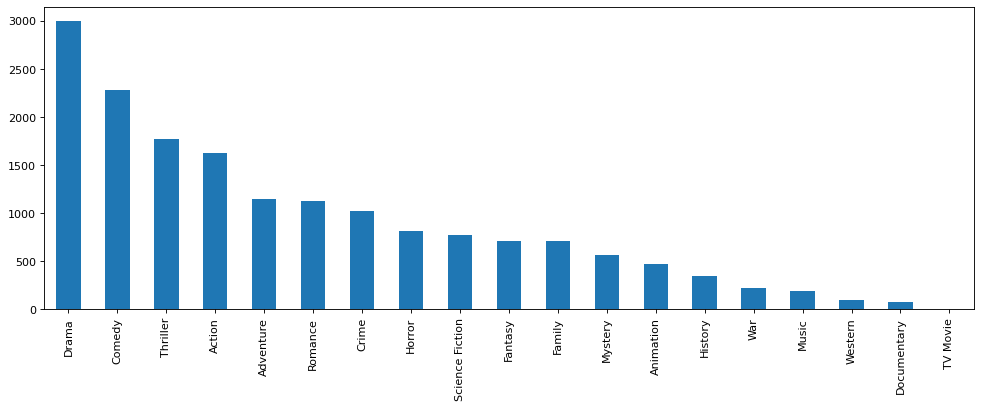

In [338]:
# Top generos

data_generos = data.copy()
data_generos2 = data_generos[data_generos['genres'] == '']
nfilas, ncolumnas = data_generos2.shape
print('Películas sin generos registrados: ' + str(nfilas))
generos = data_generos['genres'].str.split(r"-", expand=True)
df_generos_num = generos.fillna(0).apply(pd.Series.value_counts)
df_generos_num['total'] = df_generos_num.sum(axis=1)
#print('Number of 0 Values: ' + str(df_generos_num.sort_values('total', ascending=False)['total'][0]))
new_a = df_generos_num.drop([0]).sort_values('total', ascending=False)['total']
print('Prod Counts: ' + str(new_a))
figure(figsize=(15, 5), dpi=80)
new_a.head(50).plot.bar()
plt.show()

#### Matriz de correlaciones 

##### Variables dummy sobre los géneros y lenguajes de las películas

In [433]:
# Generos
data["Drama"] = (data.genres.str.contains("Drama"))
data_Drama = data.loc[data['Drama'] == True]
data['Drama'] = data['Drama'].transform(lambda x: 1 if x == True else 0)

data["Comedy"] = (data.genres.str.contains("Comedy"))
data_Comedy = data.loc[data['Comedy'] == True]
data['Comedy'] = data['Comedy'].transform(lambda x: 1 if x == True else 0)

data["Thriller"] = (data.genres.str.contains("Thriller"))
data_Thriller = data.loc[data['Thriller'] == True]
data['Thriller'] = data['Thriller'].transform(lambda x: 1 if x == True else 0)

data["Action"] = (data.genres.str.contains("Action"))
data_Action = data.loc[data['Action'] == True]
data['Action'] = data['Action'].transform(lambda x: 1 if x == True else 0)

data["Adventure"] = (data.genres.str.contains("Adventure"))
data_Adventure = data.loc[data['Adventure'] == True]
data['Adventure'] = data['Adventure'].transform(lambda x: 1 if x == True else 0)

data["Romance"] = (data.genres.str.contains("Romance"))
data_Romance = data.loc[data['Romance'] == True]
data['Romance'] = data['Romance'].transform(lambda x: 1 if x == True else 0)


In [434]:
dumis = []
categorias_80 = data['original_language'].value_counts('%')[data['original_language'].value_counts('%').cumsum()<=0.96].index
data['original_language'] = data['original_language'].apply(lambda x: x if x in categorias_80 else 'OTROS')
dumis.append(pd.get_dummies(data['original_language'],prefix='original_language'))
data_dumis = pd.concat(dumis,axis=1)
data = pd.concat([data,data_dumis],axis=1)

##### Correlaciones

In [379]:
data.corr()

budget    target   runtime     Drama    Comedy  \
budget                   1.000000  0.734250  0.256811 -0.204524 -0.030693   
target                   0.734250  1.000000  0.238013 -0.179030 -0.016482   
runtime                  0.256811  0.238013  1.000000  0.293121 -0.255971   
Drama                   -0.204524 -0.179030  0.293121  1.000000 -0.229678   
Comedy                  -0.030693 -0.016482 -0.255971 -0.229678  1.000000   
Thriller                -0.018758 -0.052022  0.010396 -0.056528 -0.365490   
Action                   0.320570  0.214238  0.079586 -0.244056 -0.183875   
Adventure                0.414625  0.351342  0.051968 -0.237842 -0.020612   
Romance                 -0.099478 -0.057119  0.062715  0.178817  0.187767   
original_language_OTROS -0.189131 -0.114256  0.084942  0.068046 -0.068526   
original_language_en     0.218377  0.143754 -0.057947 -0.083553  0.033881   
original_language_fr    -0.097482 -0.080529 -0.029621  0.044191  0.047432   

                         Thriller    Action  Adventure   Romance  \
budget                  -0.018758  0.320570   0.414625 -0.099478   
target                  -0.052022  0.214238   0.351342 -0.057119   
runtime                  0.010396  0.079586   0.051968  0.062715   
Drama                   -0.056528 -0.244056  -0.237842  0.178817   
Comedy                  -0.365490 -0.183875  -0.020612  0.187767   
Thriller                 1.000000  0.203736  -0.097409 -0.213372   
Action                   0.203736  1.000000   0.294757 -0.216234   
Adventure               -0.097409  0.294757   1.000000 -0.127094   
Romance                 -0.213372 -0.216234  -0.127094  1.000000   
original_language_OTROS -0.056047  0.034142  -0.041062 -0.020272   
original_language_en     0.077992 -0.000171   0.053885  0.012022   
original_language_fr    -0.053176 -0.054196  -0.033004  0.010376   

                         original_language_OTROS  original_language_en  \
budget                                 -0.189131              0.218377   
target                                 -0.114256              0.143754   
runtime                                 0.084942             -0.057947   
Drama                                   0.068046             -0.083553   
Comedy                                 -0.068526              0.033881   
Thriller                               -0.056047              0.077992   
Action                                  0.034142             -0.000171   
Adventure                              -0.041062              0.053885   
Romance                                -0.020272              0.012022   
original_language_OTROS                 1.000000             -0.838044   
original_language_en                   -0.838044              1.000000   
original_language_fr                   -0.063653             -0.491152   

                         original_language_fr  
budget                              -0.097482  
target                              -0.080529  
runtime                             -0.029621  
Drama                                0.044191  
Comedy                               0.047432  
Thriller                            -0.053176  
Action                              -0.054196  
Adventure                           -0.033004  
Romance                              0.010376  
original_language_OTROS             -0.063653  
original_language_en                -0.491152  
original_language_fr                 1.000000

In [380]:
# inicializamos correlación
corr = data.corr()
# Configuramos Mascara
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Tamaño figura
plt.figure(figsize=(14, 8))
# Titulo
plt.title('Overall Correlation of Titanic Features', fontsize=18)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

C:\Users\ngati\AppData\Local\Temp\ipykernel_18632\3449123885.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Si bien, las correlaciones con 'Target' deben ser analizadas con más detenimiento, se pude ver claramente que 'Budget', 'Runtime', y algunos géneros como Acción y Aventura juegan un papel preponderante en las recaudaciones de las películas.

#### Análisis de las palabras más importantes en cada uno de los labels

In [319]:
data_mpositive = data[data['label'] == 'Mostly Positive']
data_positive = data[data['label'] == 'Positive']
data_mixed = data[data['label'] == 'Mixed']
data_vpositive = data[data['label'] == 'Very Positive']
data_negative = data[data['label'] == 'Negative']

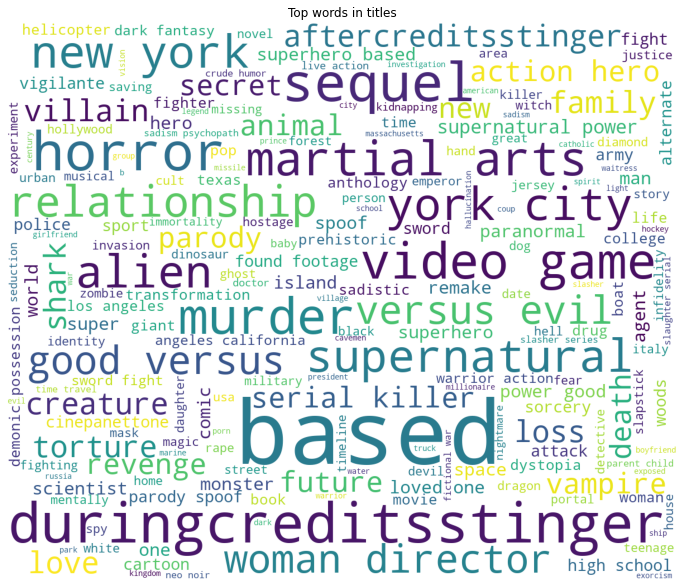

In [318]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (12, 12))
text = ' '.join(data_negative['keywords'].replace('-', ' ').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

In [320]:
plt.figure(figsize = (12, 12))
text = ' '.join(data_mpositive['keywords'].replace('-', ' ').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

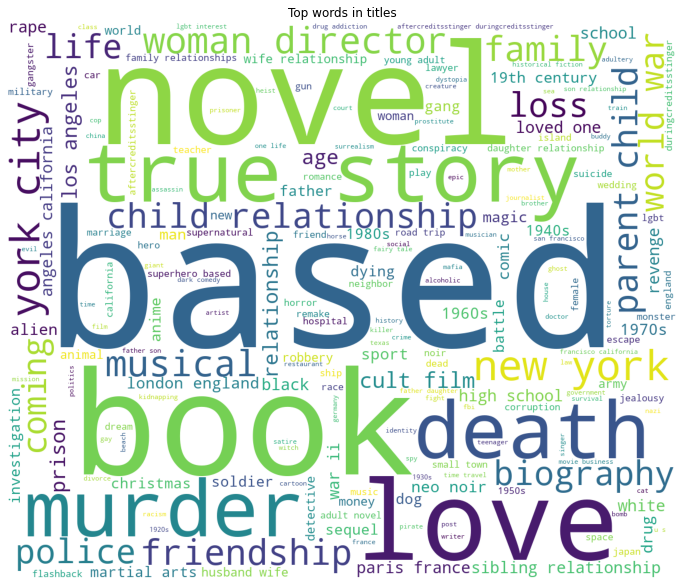

In [321]:
plt.figure(figsize = (12, 12))
text = ' '.join(data_positive['keywords'].replace('-', ' ').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

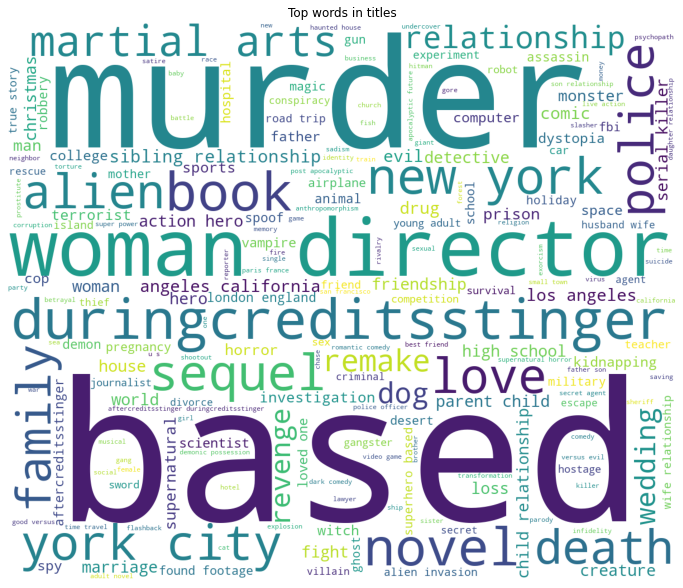

In [322]:
plt.figure(figsize = (12, 12))
text = ' '.join(data_mixed['keywords'].replace('-', ' ').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

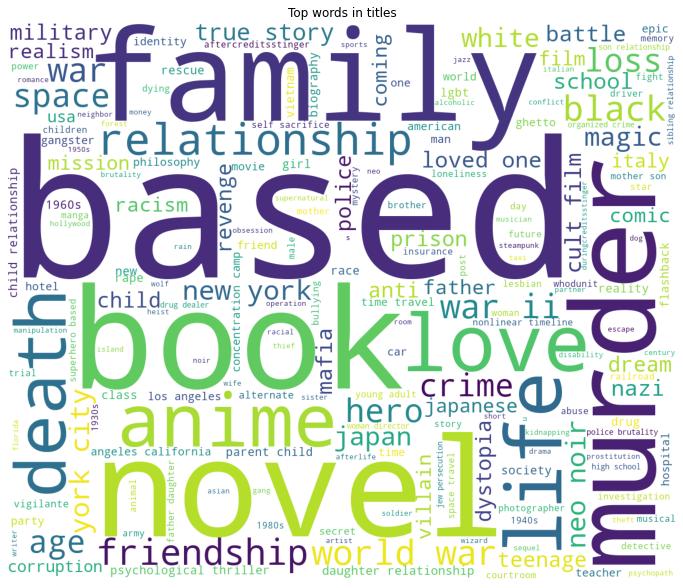

In [323]:
plt.figure(figsize = (12, 12))
text = ' '.join(data_vpositive['keywords'].replace('-', ' ').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

Dentro de las palabras clave es posible ver que gran parte de las etiquetas son bastante parecidas en cuanto a las palabras más recurrentes, sin embargo se logra ver una diferencia mayor en lo que sería la clase 'Negative'